<a href="https://colab.research.google.com/github/Kavindanipun/DL-LAB-2/blob/main/disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
import zipfile
zip_path = '/content/drive/MyDrive/disease_dataset.zip'  # Update the path to your rose disease dataset zip file
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [75]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import random
import numpy as np
import os

In [76]:
train_data_dir = '/content/disease_dataset/train'
test_data_dir = '/content/disease_dataset/test'

In [77]:
# Define your dataset and preprocessing
data_dir = '/content/disease_dataset'
image_size = (128, 128)
batch_size = 32

In [78]:
# Create data generators for both train and test datasets with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,  # Use the train_data_dir
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,  # Use the train_data_dir
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,  # Use the test_data_dir
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 214 images belonging to 4 classes.
Found 51 images belonging to 4 classes.
Found 165 images belonging to 4 classes.


In [79]:
num_classes = len(train_generator.class_indices)

In [80]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    Dropout(0.5),  # Add dropout with a specified rate
    layers.Dense(num_classes, activation='softmax')  # Update the number of output units
])

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [82]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [83]:
# Compile the model with a different evaluation metric (e.g., precision)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [84]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Add early stopping
history = model.fit(train_generator, validation_data=validation_generator, epochs=15, callbacks=[early_stopping])


Epoch 1/15
7/7 [==============================] - 10s 1s/step - loss: 1.3816 - accuracy: 0.3178 - val_loss: 1.3186 - val_accuracy: 0.3529
Epoch 2/15
7/7 [==============================] - 8s 1s/step - loss: 1.3365 - accuracy: 0.3925 - val_loss: 1.2974 - val_accuracy: 0.4902
Epoch 3/15
7/7 [==============================] - 8s 961ms/step - loss: 1.3033 - accuracy: 0.4252 - val_loss: 1.2362 - val_accuracy: 0.5686
Epoch 4/15
7/7 [==============================] - 9s 1s/step - loss: 1.2308 - accuracy: 0.4813 - val_loss: 1.1651 - val_accuracy: 0.5882
Epoch 5/15
7/7 [==============================] - 7s 958ms/step - loss: 1.2063 - accuracy: 0.4766 - val_loss: 1.1195 - val_accuracy: 0.5686
Epoch 6/15
7/7 [==============================] - 9s 1s/step - loss: 1.1524 - accuracy: 0.4907 - val_loss: 1.0327 - val_accuracy: 0.5490
Epoch 7/15
7/7 [==============================] - 7s 963ms/step - loss: 1.1820 - accuracy: 0.5140 - val_loss: 0.9973 - val_accuracy: 0.6078
Epoch 8/15
7/7 [===============

In [85]:
test_loss, test_accuracy = model.evaluate(test_generator)
test_accuracy_percentage = test_accuracy * 100
print(f'Test accuracy: {test_accuracy_percentage:.2f}%')
print(f'Test loss: {test_loss}')

6/6 [==============================] - 2s 314ms/step - loss: 0.8087 - accuracy: 0.6424
Test accuracy: 64.24%
Test loss: 0.8087367415428162


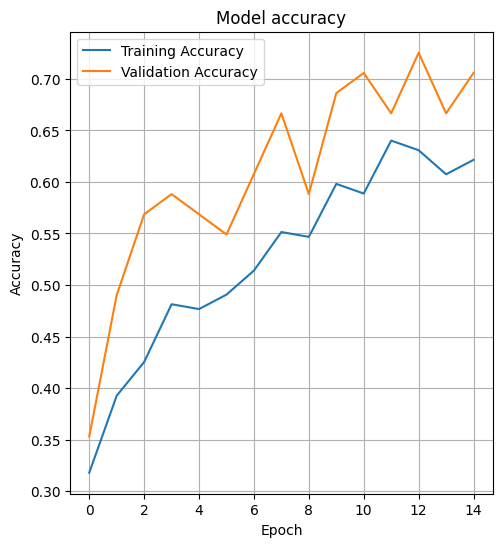

In [86]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

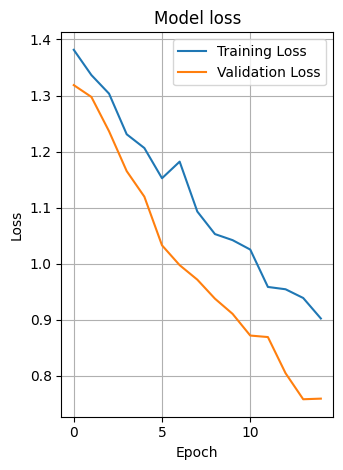

In [87]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [88]:
class_name_mapping = train_generator.class_indices

1/1 [==============================] - 0s 28ms/step


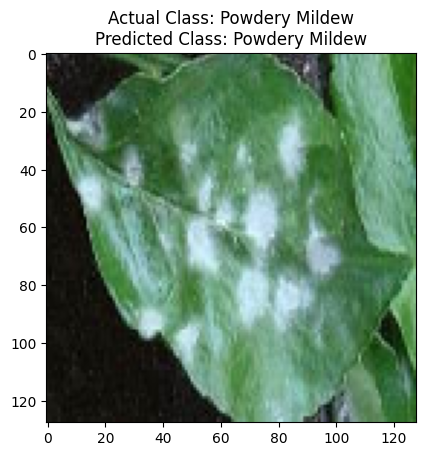

In [117]:
# ...

# Define a mapping between class indices and rose disease names
class_name_mapping = train_generator.class_indices

# Invert the class_name_mapping to get class names from indices
class_name_mapping = {v: k for k, v in class_name_mapping.items()}

# Function to predict and display a random image
def predict_random_image(model, test_data_dir, class_name_mapping, image_size):
    all_image_paths = []

    for dirpath, dirnames, filenames in os.walk(test_data_dir):
        for filename in filenames:
            if filename.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                image_path = os.path.join(dirpath, filename)
                all_image_paths.append(image_path)

    random_image_path = random.choice(all_image_paths)
    random_class = os.path.basename(os.path.dirname(random_image_path))

    img = keras.preprocessing.image.load_img(random_image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_name_mapping[predicted_class_index]

    plt.imshow(img)
    plt.title(f'Actual Class: {random_class}\nPredicted Class: {predicted_class_name}')
    plt.show()

num_samples_to_predict = 1

for _ in range(num_samples_to_predict):
    predict_random_image(model, test_data_dir, class_name_mapping, image_size)


1/1 [==============================] - 0s 49ms/step
Actual Class: Powdery Mildew
Predicted Class: Powdery Mildew
Treatment: Treatment for Powdery Mildew disease: ...


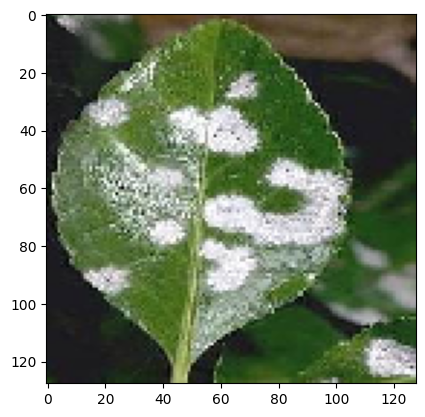

In [122]:
# Define a mapping between class indices and rose disease names
class_name_mapping = {
    0: "Black_Spot",
    1: "Botrytis_blight",
    2: "Powdery Mildew",
    3: "Rose Mosaic"
}

# Define a dictionary of treatments for each disease
disease_treatments = {
    "Black_Spot": "Treatment for Black Spot disease: ...",
    "Botrytis_blight": "Treatment for Botrytis Blight disease: ...",
    "Powdery Mildew": "Treatment for Powdery Mildew disease: ...",
    "Rose Mosaic": "Treatment for Rose Mosaic disease: ..."
}

# Function to predict and display a random image
def predict_random_image(model, test_data_dir, class_name_mapping, disease_treatments, image_size):
    all_image_paths = []

    for dirpath, dirnames, filenames in os.walk(test_data_dir):
        for filename in filenames:
            if filename.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                image_path = os.path.join(dirpath, filename)
                all_image_paths.append(image_path)

    random_image_path = random.choice(all_image_paths)
    random_class = os.path.basename(os.path.dirname(random_image_path))

    img = keras.preprocessing.image.load_img(random_image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_name_mapping[predicted_class_index]
    treatment_info = disease_treatments.get(predicted_class_name, "No specific treatment information available.")

    plt.imshow(img)
    print(f'Actual Class: {random_class}\nPredicted Class: {predicted_class_name}\nTreatment: {treatment_info}')
    plt.show()

num_samples_to_predict = 1

for _ in range(num_samples_to_predict):
    predict_random_image(model, test_data_dir, class_name_mapping, disease_treatments, image_size)
